# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: CNN GAN with FMNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_15112\4274719157.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [59]:
# download the dataset and normalize
custom_transform = T.Compose([
  T.ToTensor(),
  T.Resize(64),
  T.Normalize([.5,.5,.5],[.5,.5,.5]),
])


dataset = torchvision.datasets.CIFAR10(root='CFAR', download=True, transform=custom_transform)
# dataset = torchvision.datasets.CIFAR10(root='CFAR', download=True)

Files already downloaded and verified


In [62]:
# list the categories
print(dataset.classes)

# transform to dataloaders
batchsize   = 100
data_loader = DataLoader(dataset, batch_size=batchsize, drop_last=True, shuffle=True)

print(next(iter(data_loader))[0].data[0].shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 64, 64])


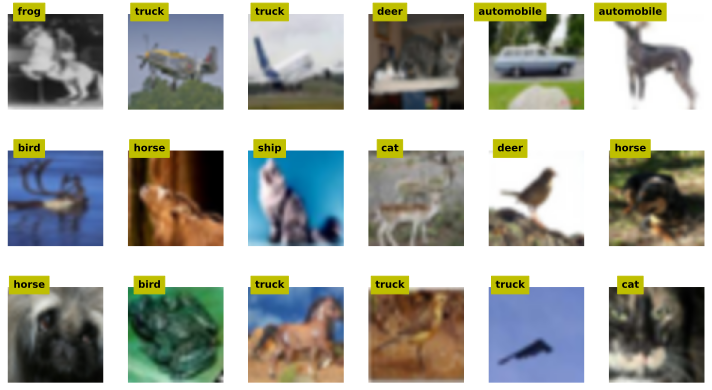

In [63]:
# view some images
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = X.data[i].detach().permute(1,2,0).numpy()
  # pic = dataset.data[i]
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[dataset.targets[i]]

  # and show!
  ax.imshow(pic)
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create classes for the discriminator and generator

In [ ]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [65]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64])


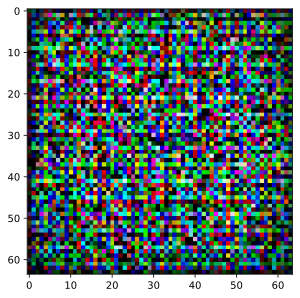

In [67]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    

gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().permute(1,2,0).numpy());

# Train the models!

In [100]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003, betas=(.5,.999))

In [101]:
# number of epochs (expressed in number of batches)
num_epochs = 15

losses  = []
disDecs = []

for epochi in range(num_epochs):

  for data,_ in data_loader:
    
    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    fake_images = gnet(fake_data)                           # output of generator
    pred_fake   = dnet(fake_images)                         # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    # compute loss
    g_loss = lossfun(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])
    
    d1 = torch.mean((pred_real>.5).float()).detach().item()
    d2 = torch.mean((pred_fake>.5).float()).detach().item()
    disDecs.append([d1,d2])


  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 15/15

In [102]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

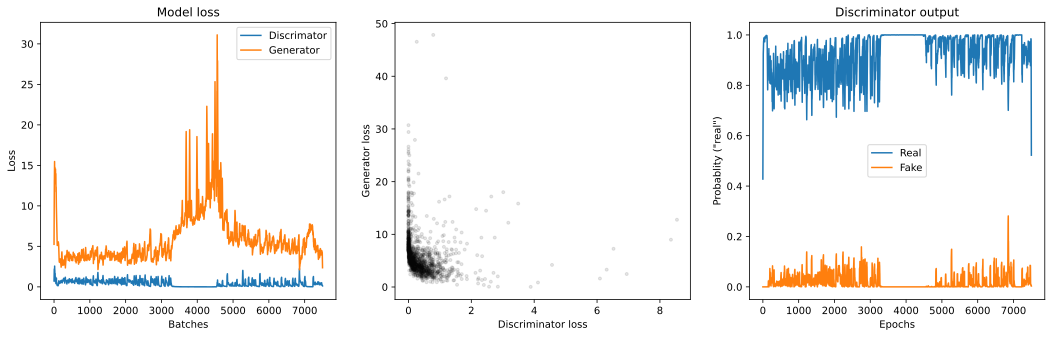

In [103]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,2300])
# ax[0].set_ylim([-.5,6])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Let's see some fake fashion!

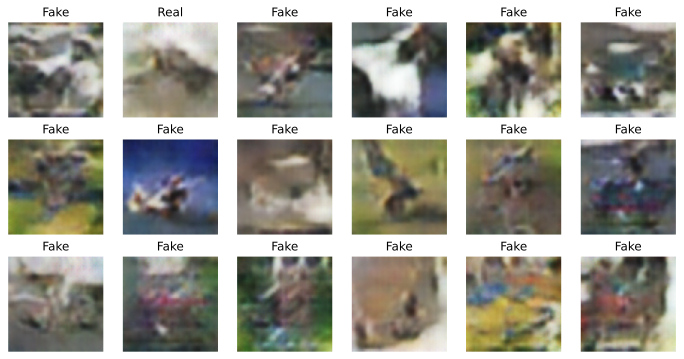

In [104]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()
real_or_fake = dnet(fake_data.to(device)).cpu().detach().squeeze().numpy()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  img = fake_data[i,:,].detach().permute(1,2,0).numpy()
  img = img/2 + .5 # undo normalization

  ax.imshow(img)
  ax.set_title("Real" if real_or_fake[i] > 0.5 else "Fake")
  ax.axis('off')

plt.show()